EE-608 Wireless Communications - Homework 04<br>
<font color="salmon">Rishabh Pomaje<br>
210020036@iitdh.ac.in

**OFDM** <br>
Implementing **O**rthogonal **F**requency **D**ivision **M**ultiplexing

> System Specifications

1. **M**odulation and **C**oding **S**cheme (**MCS**) index 3 in WiFi 6 (https://en.wikipedia.org/wiki/Wi-Fi_6)
2. 16-QAM modulation  
3. (8,4) Hamming code $\implies R = 1/2$

- A 20 MHz channel with a 1600 ns guard interval
- An 80 MHz channel with an 800 ns guard interval.

4. Average energy input to the channel power OFDM symbol = 1 unit
5. Assume transmission over a fading channel with 128 taps, each spaced 12.5 ns apart, starting from 0 ns 
6. $h \overset{iid}{\sim} \mathcal{CN}(0, 1) $ :: Channel Gain Model 
7. $w \overset{iid}{\sim} \mathcal{CN}(0, N_0)$ :: Additive-White-Gaussian-Noise

In [1]:
# Dependencies :
import numpy as np 
import matplotlib.pyplot as plt
import itertools
import tabulate
%config InlineBackend.figure_format='svg'

> Functions Definitions

In [2]:
# Function Definitions :
def hamming_encoder(input_stream, gnrtr_matrix) :
    """
    Function that first generates a codebook depending on the generator matrix 
    (provide as a numpy multi-dimensional ndarray). 
    Using that codebook, it performs the channel coding using Hamming codes.
    Returns a channel coded bit stream generated as per the Generator Matrix specified.
    """  
    input_size = len(input_stream)
    # k = length of the input packet ; n = length of the output packet
    k, n = np.shape(gnrtr_matrix)
    # Generating the codebook :
    code_book = np.array([], dtype=int)
    possible_inputs = [list(i) for i in itertools.product([0, 1], repeat=k)]
    for i in range(2 ** k) :
        code_word = np.array(np.matmul(possible_inputs[i], gnrtr_matrix) % 2)
        code_book = np.append(code_book, code_word) 
    code_book = code_book.reshape(2 ** k, n)
    # Encoding the stream using the codebook :
    index = 0
    channel_coded_stream = []
    for i in range(input_size // k) :
        temp = input_stream[index:index+k]
        asgn_id = np.sum(temp * 2 ** np.arange(k - 1, -1, -1))
        channel_coded_stream.append(code_book[int(asgn_id)])
        index = index + k
        
    channel_coded_stream = np.array(channel_coded_stream)

    return channel_coded_stream.flatten()

def QAM_16_mapper(input_stream) :
    """
    Function to perform 16-QAM Constellation Mapping with E_sym being the energy per symbol. 
    """
    if len(input_stream) % 4 != 0 :
        raise ValueError("Number of bits to be mapped must be a multiple of 4 for 16-QAM Mapping ; Try again after zero padding")
    E_sym = 10
    output_stream = []
    scale_factor = np.sqrt(E_sym / 10)  # Scale factor based on energy
    for i in range(0, len(input_stream), 4):
        bit_block = ''.join(map(str, input_stream[i:i+4]))
        if bit_block == '0000':
            output_stream.append(scale_factor * complex(-3, -3))
        elif bit_block == '0001':
            output_stream.append(scale_factor * complex(-3, -1))
        elif bit_block == '0011':
            output_stream.append(scale_factor * complex(-3, 1))
        elif bit_block == '0010':
            output_stream.append(scale_factor * complex(-3, 3))
        elif bit_block == '0110':
            output_stream.append(scale_factor * complex(-1, 3))
        elif bit_block == '0111':
            output_stream.append(scale_factor * complex(-1, 1))
        elif bit_block == '0101':
            output_stream.append(scale_factor * complex(-1, -1))
        elif bit_block == '0100':
            output_stream.append(scale_factor * complex(-1, -3))
        elif bit_block == '1100':
            output_stream.append(scale_factor * complex(1, -3))
        elif bit_block == '1101':
            output_stream.append(scale_factor * complex(1, -1))
        elif bit_block == '1111':
            output_stream.append(scale_factor * complex(1, 1))
        elif bit_block == '1110':
            output_stream.append(scale_factor * complex(1, 3))
        elif bit_block == '1010':
            output_stream.append(scale_factor * complex(3, 3))
        elif bit_block == '1011':
            output_stream.append(scale_factor * complex(3, 1))
        elif bit_block == '1001':
            output_stream.append(scale_factor * complex(3, -1))
        elif bit_block == '1000':
            output_stream.append(scale_factor * complex(3, -3))
        else:
            raise ValueError("Invalid bit block encountered during 16-QAM mapping")
    return np.array(output_stream)

def QAM_16_demapper(input_symbols):
    """
    Function to perform 16-QAM Constellation Demapping.
    """
    output_bits = []
    for symbol in input_symbols:
        symbol_real = np.real(symbol)
        symbol_imag = np.imag(symbol)
        if symbol_real < -2:
            if symbol_imag < -2:
                output_bits.append([0, 0, 0, 0])
            elif symbol_imag < 0:
                output_bits.append([0, 0, 0, 1])
            elif symbol_imag < 2:
                output_bits.append([0, 0, 1, 1])
            else:
                output_bits.append([0, 0, 1, 0])
        elif symbol_real < 0:
            if symbol_imag < -2:
                output_bits.append([0, 1, 0, 0])
            elif symbol_imag < 0:
                output_bits.append([0, 1, 0, 1])
            elif symbol_imag < 2:
                output_bits.append([0, 1, 1, 1])
            else:
                output_bits.append([0, 1, 1, 0])
        elif symbol_real < 2:
            if symbol_imag < -2:
                output_bits.append([1, 1, 0, 0])
            elif symbol_imag < 0:
                output_bits.append([1, 1, 0, 1])
            elif symbol_imag < 2:
                output_bits.append([1, 1, 1, 1])
            else:
                output_bits.append([1, 1, 1, 0])
        else:
            if symbol_imag < -2:
                output_bits.append([1, 0, 0, 0])
            elif symbol_imag < 0:
                output_bits.append([1, 0, 0, 1])
            elif symbol_imag < 2:
                output_bits.append([1, 0, 1, 1])
            else:
                output_bits.append([1, 0, 1, 0])
    
    return np.array(output_bits).flatten()

def hamming_decoder(rx_stream, parity_chk_matrix):
    """
    Function to perform hard decision syndrome decoding for Hamming codes, given a bit stream and parity check matrix 
    as input.
    Returns 't-error' corrected stream. The current implementation is matrix based and hence inefficient.
    NOTE: The matrices provided as inputs to this function must be ndarray with dtype = int.
    """
    # Get the size of the input stream and dimensions of the parity check matrix
    input_size = len(rx_stream) 
    k_1, n = np.shape(parity_chk_matrix)
    k = n - k_1
    decoded_stream = np.zeros((input_size // n, k), dtype=int)
    # Generating the syndrome book :
    possible_single_errors = np.eye(n, dtype=int) 
    syndrome_book = parity_chk_matrix.T
    # Performing the syndrome decoding :
    num_blocks = input_size // n 
    for idx in range(num_blocks):
        rx_packet = rx_stream[idx * n: (idx + 1) * n]  # Extract packet for processing
        syndrome = np.matmul(rx_packet, parity_chk_matrix.T) % 2
        if np.sum(syndrome) != 0 :
        # Correcting 1-bit errors :
            for j in range(n):
                if np.array_equal(syndrome, syndrome_book[j]):
                    rx_packet = np.bitwise_xor(rx_packet, possible_single_errors[j])
        decoded_stream[idx] = rx_packet[:k]  # Append the corrected packet
        
    return decoded_stream.flatten()

# Miscellaneous Functions for Pre/ Post Processing of the data
def str2bin(input_string) :
    """
    Function to conert a string to ASCII binary stream
    """
    # Use list comprehension to convert each character to its ASCII value and then to binary
    binary_array = [format(ord(char), '08b') for char in input_string]
    # Flatten the list of binary strings into a single list of integers
    binary_array = [int(bit) for binary_str in binary_array for bit in binary_str]
    return np.array(binary_array, dtype=int)

def bin2str(binary_array) :
        # Conversion to byte array :
        byte_array = np.packbits(binary_array)
        # Decode byte array to ASCII string :
        return byte_array.tobytes().decode('ascii')


def calcBLER(original_message, estimated_message, block_length) :
    """ 
    Function to calculate the block error rate 
    """
    n_errors = 0
    n_blocks = len(original_message) // block_length
    idx = 0
    for _ in range(n_blocks) :
        if not np.all(original_message[idx:idx+block_length] == estimated_message[idx:idx+block_length]) :
            n_errors += 1 
        idx += block_length  
    return [n_errors, n_errors / n_blocks]    

> Parameter Definitions 

In [3]:
# System Specifications :
# Given information :
mcs_idx = 3                                                         # Only for reference (as per WiFi 6)
k = 4                                                               # input block length
n = 8                                                               # output block length
R = k / n                                                           # Information rate
BW = np.array([20 * (10 ** 6), 80 * (10 ** 6)])                     # Bandwidths [BW1, BW2] in Hz
GI = np.array([1600 * (10 ** -9), 800 * (10 ** -9)])                # Guard intervals [GI1, GI2] in seconds
OFDM_energy = 1
tap_interval = 12.5 * (10 ** -9)
# Inferred information :
T_s = 1 / BW                                                        # Symbol duration without OFDM
# T = num_taps * tap_interval                                       # Symbol Duration with OFDM T = N*T_s
T= 12.8 * (10 ** -6)                                                # Symbol Duration with OFDM T = N*T_s
num_subcarriers = np.array(T / T_s, dtype=int)                      # _ per OFDM block
num_prefixes = np.array(GI / T_s, dtype=int)                        # _ per OFDM block
num_taps = num_prefixes + 1
# Displaying :
table = (
    ["Entity\Bandwidth", f'{BW[0] / (10 ** 6)} MHz', f'{BW[1] / (10 ** 6)} MHz'], 
    ["OFDM symbol energy", OFDM_energy, OFDM_energy],
    ["# of fade taps", num_taps[0], num_taps[1]],
    ["Coherence Period", tap_interval, tap_interval],
    ["GI", GI[0], GI[1]],
    ["T_s", T_s[0], T_s[1]],
    ["T", T, T],
    ["# of Sub-Carriers (N)", num_subcarriers[0], num_subcarriers[1]],
    ["# of Cyclic Prefixes", num_prefixes[0], num_prefixes[1]]
    )
print(tabulate.tabulate(table, headers="firstrow", tablefmt="grid"))

+-----------------------+------------+-------------+
| Entity\Bandwidth      |   20.0 MHz |    80.0 MHz |
+=======================+============+=============+
| OFDM symbol energy    |   1        |    1        |
+-----------------------+------------+-------------+
| # of fade taps        |  33        |   65        |
+-----------------------+------------+-------------+
| Coherence Period      |   1.25e-08 |    1.25e-08 |
+-----------------------+------------+-------------+
| GI                    |   1.6e-06  |    8e-07    |
+-----------------------+------------+-------------+
| T_s                   |   5e-08    |    1.25e-08 |
+-----------------------+------------+-------------+
| T                     |   1.28e-05 |    1.28e-05 |
+-----------------------+------------+-------------+
| # of Sub-Carriers (N) | 256        | 1024        |
+-----------------------+------------+-------------+
| # of Cyclic Prefixes  |  32        |   64        |
+-----------------------+------------+--------

In [4]:
# The generator and the parity check matrices for (8, 4) Hamming Code :
# In systematic form :
G = np.array([
    [1, 0, 0, 0, 0, 1, 1, 1],
    [0, 1, 0, 0, 1, 0, 1, 1],
    [0, 0, 1, 0, 1, 1, 0, 1],
    [0, 0, 0, 1, 1, 1, 1, 0]
    ], dtype=int)

H = np.array([
    [0, 1, 1, 1, 1, 0, 0, 0],
    [1, 0, 1, 1, 0, 1, 0, 0],
    [1, 1, 0, 1, 0, 0, 1, 0],
    [1, 1, 1, 0, 0, 0, 0, 1]
    ], dtype=int)

> Pre-Processing the input data 
- Converting the text to a bit stream

In [5]:
# Loading the data :
with open("text_data.txt", mode='r') as file_id :
    binary_tx = str(file_id.read())

# Converting the data to binary :
# binary_tx = binary stream at the transmitter
binary_tx = str2bin(binary_tx)
print(f'binary_input_string = {binary_tx}')

binary_input_string = [0 1 0 ... 1 1 0]


> Transmitter Block Processing :

Part I : Zero Padding + Channel Coding + Constellation Mapping

In [14]:
# Zero Padding the input for further processing :
# This is to make sure that 
if len(binary_tx) % 512 != 0 :
    binary_tx = np.append(binary_tx, np.zeros(512 - (len(binary_tx) % 512), dtype=int))

# Channel Coding : ccoded_tx = channel coded stream of bits at the transmitter
ccoded_tx = hamming_encoder(binary_tx, G)

# Constellation Mapping : csymbols_tx = constellation symbol stream at the transmitter
csymbols_tx = QAM_16_mapper(ccoded_tx)
print(csymbols_tx)

[-1.-1.j -1.-1.j -1.+1.j ... -3.-3.j -3.-3.j -3.-3.j]


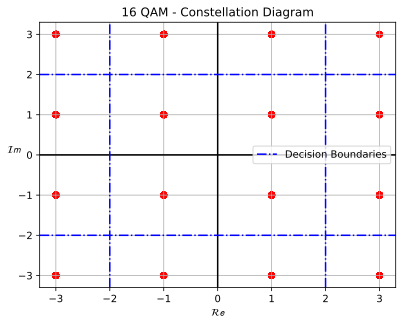

In [7]:
fig, axes = plt.subplots()
numPt = 1000
axes.scatter(np.real(csymbols_tx[:numPt]), np.imag(csymbols_tx[:numPt]), color='red')
axes.grid()
axes.set_xlabel(r'$\mathcal{Re}$')
axes.set_ylabel(r'$\mathcal{Im}$', rotation=0)
axes.set_title("16 QAM - Constellation Diagram")
axes.axhline(c='black')
axes.axvline(c='black')

axes.axhline(y=2, c='blue', ls='-.', label="Decision Boundaries")
axes.axhline(y=-2, c='blue', ls='-.')
axes.axvline(x=2, c='blue', ls="-.")
axes.axvline(x=-2, c='blue', ls="-.")
axes.legend()

Part II : Formation of the OFDM blocks
1. Case : 20Mhz BW and 1600ns GI 

In [8]:
OFDM_tx_c1 = []
num_OFDMsyms_c2 = len(csymbols_tx) // num_subcarriers[0]
idx = 0 
for _ in range(num_OFDMsyms_c2) :
    # Taking the IFFT to convert to time domain :
    temp = np.fft.ifft(csymbols_tx[idx:idx+num_subcarriers[0]], norm="ortho")
    # Appending the prefixes :
    temp = np.append(temp, temp[-1*(num_prefixes[0]):])
    # Performing the cyclic shifts :
    temp = np.roll(temp, num_prefixes[0])
    # Normalising the energy of the OFDM Symbol : OFDM_energy = 1 
    temp = OFDM_energy * (temp / np.linalg.norm(temp))
    # Appending the generated the OFDM Symbol :
    OFDM_tx_c1.append(temp)
    idx = idx + num_subcarriers[0]
# Final OFDM Symbol stream to be put on the channel
OFDM_tx_c1 = np.array(OFDM_tx_c1).flatten()
# Appending dummy symbols : # of Dummy symbols = 32 = Number of Prefixes
OFDM_tx_c1 = np.roll(np.append(OFDM_tx_c1, np.full(num_prefixes[0], 1+1j)), num_prefixes[0])

2. Case : 80Mhz BW and 800ns GI 

In [9]:
OFDM_tx_c2 = []
num_OFDMsyms_c2 = len(csymbols_tx) // num_subcarriers[1]
idx = 0 
for i in range(num_OFDMsyms_c2) :
    # Taking the IFFT to convert to time domain :
    temp = np.fft.ifft(csymbols_tx[idx:idx+num_subcarriers[1]], norm="ortho")
    # Appending the prefixes :
    temp = np.append(temp, temp[-1*(num_prefixes[1]):])
    # Performing the cyclic shifts :
    temp = np.roll(temp, num_prefixes[1])
    # Normalising the energy of the OFDM Symbol : OFDM_energy = 1 
    temp = OFDM_energy * (temp / np.linalg.norm(temp))
    # Appending the generated the OFDM Symbol :
    OFDM_tx_c2.append(temp)
    idx = idx + num_subcarriers[1]
# Final OFDM Symbol stream to be put on the channel
OFDM_tx_c2 = np.array(OFDM_tx_c2).flatten()
# Appending dummy symbols : # of Dummy symbols = 32 = Number of Prefixes
OFDM_tx_c2 = np.roll(np.append(OFDM_tx_c2, np.full(num_prefixes[1], 1+1j)), num_prefixes[1])

> Channel 

Case 1 : For 20 Mhz and 1600 ns GI

In [10]:
# Generating the Rayleigh Fading Taps
fade_taps_c1 = np.random.normal(0, np.sqrt(0.5), num_taps[0]) + 1j*np.random.normal(0, np.sqrt(0.5), num_taps[0])
# FFT for Future use :
FADE_c1 = np.sqrt(num_subcarriers[0]) * np.fft.fft(fade_taps_c1, n=num_subcarriers[0], norm="ortho")
# Performing convolution to simulate the effect of the channel in discrete time :
OFDM_rx_c1 = np.convolve(fade_taps_c1, OFDM_tx_c1) 

Case 2 : For 80 Mhz and 800ns GI

In [11]:
# Generating the Rayleigh Fading Taps
fade_taps_c2 = np.random.normal(0, np.sqrt(0.5), num_taps[1]) + 1j*np.random.normal(0, np.sqrt(0.5), num_taps[1])
# FFT for Future use :
FADE_c2 = np.sqrt(num_subcarriers[1]) * np.fft.fft(fade_taps_c2, n=num_subcarriers[1], norm="ortho")
# Performing convolution to simulate the effect of the channel in discrete time :
OFDM_rx_c2 = np.convolve(fade_taps_c2, OFDM_tx_c2) 

> Receiver Processing

NOTE : Adding noise will result in bit errors. It might happen that the byte values might go above 128 which is not allowed in ASCII. Hence just to demonstrate that the text data can be encoded and decoded correctly, no noise will be added here. Only Fading will be considered. For BLER (Block error rates) check the other file.

For 20Mhz BW and 1600ns GI

Decoded Text Data :
--------------------------------------------------------------------------
Wireless communication is one of the most vibrant areas in the communication field
today. While it has been a topic of study since the 1960's, the past decade has seen a
surge of research activities in the area. This is due to a confluence of several factors.
First is the explosive increase in demand for tetherless connectivity, driven so far
mainly by cellular telephony but is expected to be soon eclipsed by wireless data
applications. Second, the dramatic progress in VLSI technology has enabled small-area
and low-power implementation of sophisticated signal processing algorithms and coding
techniques. Third, the success of second-generation (2G) digital wireless standards,
in particular, the IS-95 Code Division Multiple Access (CDMA) standard, provides
a concrete demonstration that good ideas from communication theory can have a
significant impact in practice. The research thrust in the pas

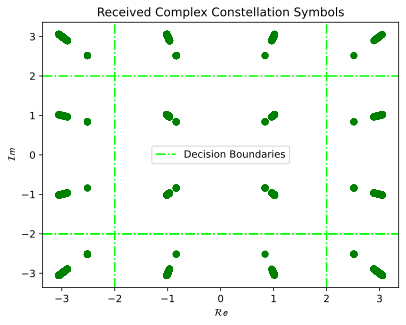

In [12]:
# For simplicity no noise is added. For BLER with AWGN, check the other file
# Removing the excess (Dummy Symbol + Residual at the end) 
OFDM_clear_c1 = OFDM_rx_c1[num_prefixes[0]:-1*(num_prefixes[0])]
# Dropping the prefixes :
OFDM_sliced_c1 = []
idx = 0 
while idx < len(OFDM_clear_c1) :
    if (idx % (num_subcarriers[0] + num_prefixes[0]) == 0) :
        idx = idx + num_prefixes[0]
    else :
        OFDM_sliced_c1.append(OFDM_clear_c1[idx])
        idx = idx + 1 
OFDM_sliced_c1 = np.array(OFDM_sliced_c1).reshape(-1,num_subcarriers[0])

# Taking the FFT block-by-block:
for pkt_id in range(len(OFDM_sliced_c1)) :
    OFDM_sliced_c1[pkt_id] = np.fft.fft(OFDM_sliced_c1[pkt_id], norm="ortho")

# Performing decoding of the received OFDM symbols
csymbols_rx_c1 = [] 
for i in range(len(OFDM_sliced_c1)):
    Y = OFDM_sliced_c1[i]
    # Rectifying using H*Y/|H|
    Y = (np.conjugate(FADE_c1) / (np.abs(FADE_c1) ** 2)) * Y 
    # Adjusting the constellation symbol energy since we had normalised the ODFM block energy
    adjust_factor = np.sqrt(10 * (num_prefixes[0] + num_subcarriers[0]))
    Y = Y * adjust_factor
    csymbols_rx_c1.append(Y) # First appending the rectified complex symbols

# 16-QAM Demodulation using MLD --> Minimum Distance Rule :
ccoded_rx_c1 = QAM_16_demapper(np.array(csymbols_rx_c1).flatten())

# Performing Hamming (8, 4) syndrome decoding :
binary_rx_c1 = hamming_decoder(ccoded_rx_c1, H)

# Post-Processing of the binary data --> Final estimate of the message :
# Convert binary array to bytes
print("Decoded Text Data :")
print("--------------------------------------------------------------------------")
print(bin2str(binary_rx_c1))
print("--------------------------------------------------------------------------")
fig, axes = plt.subplots()
axes.scatter(np.real(csymbols_rx_c1), np.imag(csymbols_rx_c1), color='green')
axes.set_xlabel(r'$\mathcal{Re}$')
axes.set_ylabel(r'$\mathcal{Im}$')
axes.set_title("Received Complex Constellation Symbols")
axes.axhline(y=2, c='lime', ls='-.', label="Decision Boundaries")
axes.axhline(y=-2, c='lime', ls='-.')
axes.axhline(y=-2, c='lime', ls='-.')
axes.axvline(x=2, c='lime', ls="-.")
axes.axvline(x=-2, c='lime', ls="-.")
axes.legend()

For 80 MHz BW and 800ns GI

Decoded Text Data :
--------------------------------------------------------------------------
Wireless communication is one of the most vibrant areas in the communication field
today. While it has been a topic of study since the 1960's, the past decade has seen a
surge of research activities in the area. This is due to a confluence of several factors.
First is the explosive increase in demand for tetherless connectivity, driven so far
mainly by cellular telephony but is expected to be soon eclipsed by wireless data
applications. Second, the dramatic progress in VLSI technology has enabled small-area
and low-power implementation of sophisticated signal processing algorithms and coding
techniques. Third, the success of second-generation (2G) digital wireless standards,
in particular, the IS-95 Code Division Multiple Access (CDMA) standard, provides
a concrete demonstration that good ideas from communication theory can have a
significant impact in practice. The research thrust in the pas

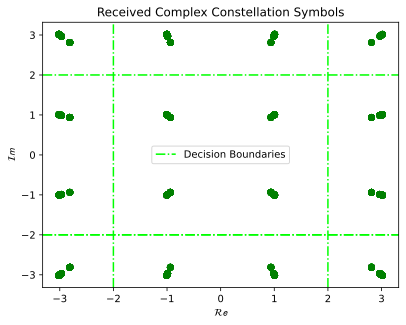

In [13]:
# For simplicity no noise is added. For BLER with AWGN, check the other file
# Removing the excess (Dummy Symbol + Residual at the end) 
OFDM_clear_c2 = OFDM_rx_c2[num_prefixes[1]:-1*(num_prefixes[1])]
# Dropping the prefixes :
OFDM_sliced_c2 = []
idx = 0 
while idx  < len(OFDM_clear_c2) :
    if (idx % (num_subcarriers[1] + num_prefixes[1]) == 0) :
        idx = idx + num_prefixes[1]
    else :
        OFDM_sliced_c2.append(OFDM_clear_c2[idx])
        idx = idx + 1 
OFDM_sliced_c2 = np.array(OFDM_sliced_c2).reshape(-1,num_subcarriers[1])

# Taking the FFT block-by-block:
for pkt_id in range(len(OFDM_sliced_c2)) :
    OFDM_sliced_c2[pkt_id] = np.fft.fft(OFDM_sliced_c2[pkt_id], norm="ortho")

# Performing decoding of the received OFDM symbols
csymbols_rx_c2 = [] 
for i in range(len(OFDM_sliced_c2)):
    Y = OFDM_sliced_c2[i]
    # Rectifying using H*Y/|H|
    Y = (np.conjugate(FADE_c2) / (np.abs(FADE_c2) ** 2)) * Y 
    # Adjusting the constellation symbol energy since we had normalised the ODFM block energy
    adjust_factor = np.sqrt(10 * (num_prefixes[1] + num_subcarriers[1]))
    Y = Y * adjust_factor
    csymbols_rx_c2.append(Y) # First appending the rectified complex symbols

# 16-QAM Demodulation using MLD --> Minimum Distance Rule :
ccoded_rx_c2 = QAM_16_demapper(np.array(csymbols_rx_c2).flatten())

# Performing Hamming (8, 4) syndrome decoding :
binary_rx_c2 = hamming_decoder(ccoded_rx_c2, H)

# Post-Processing of the binary data --> Final estimate of the message :
# Convert binary array to bytes
print("Decoded Text Data :")
print("--------------------------------------------------------------------------")
print(bin2str(binary_rx_c2))
print("--------------------------------------------------------------------------")
fig, axes = plt.subplots()
axes.scatter(np.real(csymbols_rx_c2), np.imag(csymbols_rx_c2), color='green')
axes.set_xlabel(r'$\mathcal{Re}$')
axes.set_ylabel(r'$\mathcal{Im}$')
axes.set_title("Received Complex Constellation Symbols")
axes.axhline(y=2, c='lime', ls='-.', label="Decision Boundaries")
axes.axhline(y=-2, c='lime', ls='-.')
axes.axhline(y=-2, c='lime', ls='-.')
axes.axvline(x=2, c='lime', ls="-.")
axes.axvline(x=-2, c='lime', ls="-.")
axes.legend()